In [1698]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.special import logsumexp
import tqdm
import time

In [1699]:
a = np.random.randint(0,10, size = (2,3))
print(a)
b = a - np.array([1,2,3])
print(b)

[[9 8 4]
 [0 2 8]]
[[ 8  6  1]
 [-1  0  5]]


In [1700]:
def h(pars, size):
    return norm.rvs(loc = 0, scale = np.random.choice(pars[1:], p = [pars[0],1-pars[0]], size = size))

def h2(pars, x, sn, size):
    acp = []
    ac = 0
    n = np.prod(size)
    while ac < n:
        acs = norm.rvs(loc = 0, scale = np.random.choice(pars[1:], p = [pars[0],1-pars[0]], size = n))
        ps = norm.pdf( acs, loc = x, scale = sn)
        tr = np.random.uniform(0,1,n) - ps
        temp = acs[tr<=0]
        ac+=len(temp)
        acp.append(temp)
    return np.reshape( np.hstack(acp)[:n], size )

def ips(h, s, trans):
    return s + trans[0]*np.arctan( ( h - s ) / trans[1] ) 

def loglikelihood(s, vn, pars):
    return np.sum( np.log( pars[0]*norm.pdf(s, loc = 0, scale = np.sqrt( vn + pars[1]**2 )  ) + (1-pars[0])*norm.pdf(s, loc = 0, scale = np.sqrt( vn + pars[2]**2 ) ) ) )

def likelihood(s, vn, pars):
    return pars[0]*norm.pdf(s, loc = 0, scale = np.sqrt( vn + pars[1]**2 )  ) + (1-pars[0])*norm.pdf(s, loc = 0, scale = np.sqrt( vn + pars[2]**2 ) ) 

def replace_inf_nan(array):
    array[np.isinf(array)] = np.finfo(array.dtype).max
    array[np.isnan(array)] = 0
    return array

def jac(h, s, trans):
    return (trans[1]**2 + (h-s)**2)/(trans[0]*trans[1])

def sampling(n, x, sn, scale, n_avg):
    vn = sn**2
    lenx = len(x)
    samples = []
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 10, 10])
    pars = np.array([0.5, 0.5, 0.5])
    logl = logsumexp( np.sum( norm.logpdf( h(pars, (n_avg,lenx)) , loc = x, scale = sn), axis = 1 ) ) 
    plog = np.log(np.random.uniform(0,1,n))
    c = 0
    pb = tqdm.tqdm(range(n))
    medie = pars
    pacc = []
    pacc_an = []
    sigmacc = 0
    sigmacc_an = 0
    acc_an = 0
    for i in pb:
        acp = i and c/i or 0
        if c > 2 : medie = np.mean( np.array( samples ), axis = 0 )
        pb.set_description("[Acceptance rate (real vs an)= %f, %f ] | [Acceptance std_dev(num vs an)= %.2e, %.2e ] | [pars mean = %f, %f, %f ] | [logl = %f ]" % (acp, acc_an, sigmacc, sigmacc_an, medie[0], medie[1], medie[2], logl ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        #print(pars_pr)
        logl_pr = logsumexp( np.sum( norm.logpdf( h(pars_pr, (n_avg,lenx)) , loc = x, scale = sn), axis = 1 ) )
        a = logl_pr - logl
        pacc.append( np.exp(a) )
        pacc_an.append( np.exp( loglikelihood(x, vn, pars_pr) - loglikelihood(x, vn, pars) ) )
        sigmacc = np.sqrt( np.var( np.array( replace_inf_nan( np.array(pacc) ) ) ) )
        sigmacc_an = np.sqrt( np.var( np.array( pacc_an ) ) )
        acc_an = np.sqrt( np.mean( pacc_an ) )
        #print(logl_pr, '\n')
        if plog[i] <= a:
            logl= logl_pr
            pars = pars_pr
            #print(pars)
            c+=1
        samples.append(pars)
    return np.array(samples)

def sampling2(n, x, sn, scale, n_avg, trans):
    vn = sn**2
    lenx = len(x)
    samples = []
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 3, 3])
    pars = np.array([0.5, 0.5, 0.5])
    acca = h(pars, (n_avg,lenx))
    y = ips(acca, x, trans)
    #logl = logsumexp( np.sum( norm.logpdf( y , loc = x, scale = sn), axis = 1 ) )
    logl = np.sum( norm.logpdf( y , loc = x, scale = sn) )
    plog = np.log(np.random.uniform(0,1,n))
    c = 0
    pb = tqdm.tqdm(range(n))
    medie = pars
    pacc = []
    pacc_an = []
    sigmacc = 0
    sigmacc_an = 0
    acc_an = 0
    for i in pb:
        acp = i and c/i or 0
        if c > 2 : medie = np.mean( np.array( samples ), axis = 0 )
        pb.set_description("[Acceptance rate (real vs an)= %f, %f ] | [Acceptance std_dev(num vs an)= %.2e, %.2e ] | [pars mean = %f, %f, %f ] | [logl = %f ]" % (acp, acc_an, sigmacc, sigmacc_an, medie[0], medie[1], medie[2], logl ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        if pars_pr[1]>pars_pr[2]:
            continue
        #print(pars_pr)
        #logl_pr = logsumexp( np.sum( norm.logpdf( ips(pars_pr, (n_avg,lenx), trans) , loc = x, scale = sn), axis = 1 ) )
        acca_pr = h(pars_pr, (n_avg,lenx))
        y_pr = ips(acca_pr, x, trans)
        #logl_pr = logsumexp( np.sum( norm.logpdf( y_pr , loc = x, scale = sn), axis = 1 ) ) 
        logl_pr = np.sum( norm.logpdf( y_pr , loc = x, scale = sn) ) 
        a = logl_pr - logl + np.sum( np.log( jac(acca, x, trans) ) - np.log( jac(acca_pr, x, trans) ) )
        pacc.append( np.exp(a) )
        pacc_an.append( np.exp( loglikelihood(x, vn, pars_pr) - loglikelihood(x, vn, pars) ) )
        sigmacc = np.sqrt( np.var( np.array( replace_inf_nan( np.array(pacc) ) ) ) )
        sigmacc_an = np.sqrt( np.var( np.array( pacc_an ) ) )
        acc_an = np.mean( pacc_an[-100:] ) 
        #print(logl_pr, '\n')
        if plog[i] <= a:
            logl= logl_pr
            pars = pars_pr
            #print(pars)
            c+=1
        samples.append(pars)
    return np.array(samples)


def sampling3(n, x, sn, scale, n_avg, trans, tg):
    vn = sn**2
    lenx = len(x)
    samples = []
    samples2 = []
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 3, 3])
    pars = np.array([0.5, 0.5, 0.5])
    acca = h(pars, (n_avg,lenx))
    y = ips(acca, x, trans)
    logl = np.sum( norm.logpdf( y , loc = x, scale = sn) )
    plog = np.log(np.random.uniform(0,1,n))
    c = 0
    medie = np.zeros(3)
    pb = tqdm.tqdm(range(n))
    for i in pb:
        acp = i and c/i or 0
        if i > 2: medie = medie*( (i-1)/(i) ) + pars/i
        pb.set_description("[Acceptance rate = %f ] | [pars mean = %f, %f, %f ] | [logl = %f ] | trans1 = %f" % (acp, medie[0], medie[1], medie[2], logl, trans[1] ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        if pars_pr[1]>pars_pr[2]:
            continue
        acca_pr = h(pars_pr, (n_avg,lenx))
        y_pr = ips(acca_pr, x, trans)
        logl_pr = np.sum( norm.logpdf( y_pr , loc = x, scale = sn) ) 
        if plog[i] <= ( logl_pr - logl + np.sum( np.log( jac(acca, x, trans) ) - np.log( jac(acca_pr, x, trans) ) ) ):
            logl= logl_pr
            pars = pars_pr
            c+=1
        samples.append(pars)
        samples2.append(pars)
        if acp < tg :
            trans[1]*=1.01
            samples2 = []
        elif acp > tg+0.15: 
            trans[1]*=0.99
            samples2 = []
    return np.array(samples), np.array(samples2)

def tg_acp(n, x, sn, scale):
    vn = sn**2
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 3, 3])
    pars = np.array([0.5, 0.5, 0.5])
    logl = loglikelihood(x, vn, pars)
    plog = np.log(np.random.uniform(0,1,n))
    c = 0
    pb = tqdm.tqdm(range(n))
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("[Analytic acceptance rate = %f ] " % ( acp ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        logl_pr = loglikelihood(x, vn, pars_pr)
        if pars_pr[1]>pars_pr[2]:
            continue
        if plog[i] <= ( logl_pr - logl ):
            pars = pars_pr
            logl = logl_pr
            c+=1
    return acp

def sampling4(n, x, sn, scale, n_avg, trans, n_tg):
    tg = tg_acp(n_tg, x, sn, scale)
    vn = sn**2
    lenx = len(x)
    samples = []
    samples2 = []
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 3000, 3000])
    pars = np.array([0.5, 0.5, 0.5])
    #acca = h(np.array([pars[0], pars[1]/trans, pars[2]/trans]), (n_avg,lenx))
    acca = h(pars, (n_avg,lenx))
    #y = x + trans*acca
    y = trans*acca
    logl = np.sum( norm.logpdf( y , loc = x, scale = sn) )
    #logl = logsumexp( np.sum( norm.logpdf( y , loc = x, scale = sn), axis = 1 ) ) 
    plog = np.log(np.random.uniform(0,1,n))
    c, c2, acp2, j = 0, 0, 0, 0
    medie = np.zeros(3)
    pb = tqdm.tqdm(range(n))
    emme = []
    for i in pb:
        j+=1
        acp = i and c/i or 0
        pb.set_description("[Acceptance rate = %f ] | [acp2 = %f] | [pars mean = %f, %f, %f ] | [logl = %f ] | trans = %f" % (acp, acp2, medie[0], medie[1], medie[2], logl, trans ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        if pars_pr[1]>pars_pr[2]:
            continue
        #acca_pr = h(np.array([pars_pr[0], pars_pr[1]/trans, pars_pr[2]/trans]), (n_avg,lenx))
        acca_pr = h(pars_pr, (n_avg,lenx))
        #y_pr = x + trans*acca_pr
        y_pr = trans*acca_pr
        logl_pr = np.sum( norm.logpdf( y_pr , loc = x, scale = sn) ) 
        #logl_pr = logsumexp( np.sum( norm.logpdf( y_pr , loc = x, scale = sn), axis = 1 ) ) 
        if plog[i] <= ( logl_pr - logl ):
            logl= logl_pr
            pars = pars_pr
            #emme.append( np.sum( acca_pr**2 - acca**2) )            
            c+=1
            #c2+=1
        samples.append(pars)
        #samples2.append(pars)
        if i > 2 : 
            medie = medie*( (i-1)/(i) ) + pars/i
        #if i < n/10:
        #    if i%100 == 0:
        #        acp2 = c2/j
        #        if acp2 < tg-0.025 :
        #            trans*=0.9
        #            if i%1000==0:
        #                samples2 = []
        #                c2, j = 0, 0
        #        elif acp2 > tg+0.025: 
        #            trans*=1.1
        #            if i%1000==0:
        #                samples2 = []
        #                c2, j = 0, 0
        #else: acp2 = c2/j
    return np.array(samples), np.array(samples2)


def sampling_an(n, x, sn, scale):
    vn = sn**2
    #lenx = len(x)
    samples = []
    a_trunc = np.array([0, 0 , 0])
    b_trunc = np.array([1, 3, 3])
    pars = np.array([0.5, 0.5, 0.5])
    logl = loglikelihood(x, vn, pars)
    plog = np.log(np.random.uniform(0,1,n))
    c = 0
    pb = tqdm.tqdm(range(n))
    medie = pars
    for i in pb:
        acp = i and c/i or 0
        if i > 2 : medie = medie*( (i-1)/(i) ) + pars/i
        pb.set_description("[Acceptance rate = %f ] | [pars mean = %f, %f, %f ] | [logl = %f ]" % (acp, medie[0], medie[1], medie[2], logl ) )
        a, b = (a_trunc - pars) / scale, (b_trunc - pars) / scale
        pars_pr = truncnorm.rvs(a, b, loc=pars, scale=scale)
        logl_pr = loglikelihood(x, vn, pars_pr)
        if pars_pr[1]>pars_pr[2]:
            continue
        if plog[i] <= ( logl_pr - logl ):
            pars = pars_pr
            logl = logl_pr
            c+=1
        samples.append(pars)
    return np.array(samples)

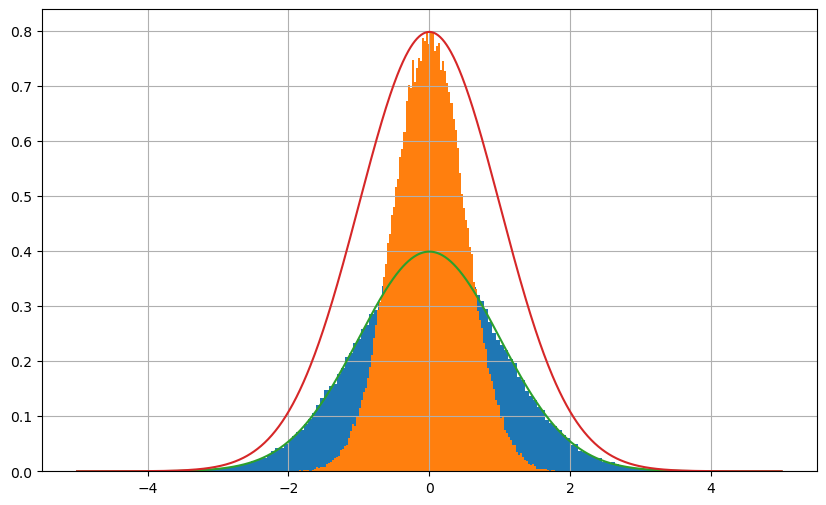

In [1701]:
m = 0.5
a = norm.rvs(loc = 0, scale = 1, size=100000)
a2 = m*a
x = np.linspace(-5,5,1000)
y = norm.pdf(x, loc = 0, scale = 1)
y2 = y/m
plt.figure(figsize=[10,6])
plt.hist(a, bins='auto', density = True)
plt.hist(a2, bins='auto', density = True)
plt.plot(x,y)
plt.plot(x,y2)
plt.grid()
plt.show()

In [1702]:
l1 = []
l2 = []
n = int(1e4)
s = h(parss, (1,n)) + np.random.normal(0, sn, n)
for _ in range(1000):

    acca = h(parss, (1,n))
    l1.append( np.sum( norm.logpdf(acca, loc = s, scale = 1) ) )

    m = 0.01
    acca = h( np.array([parss[0], parss[1]/m, parss[2]/m]), (1,n))
    macca = m*acca
    l2.append( np.sum( norm.logpdf(macca, loc = s, scale = 1) ) )

l1 = logsumexp( np.array(l1) )
l2 = logsumexp( np.array(l2) )
print(np.mean(l1))
print( np.mean(l2))
print(np.mean(l1) - np.mean(l2))

-14236.893283729816
-14245.93721798962
9.043934259803791


In [1703]:
n = int(1e5)

sn = 1
vn = sn**2
parss = np.array([0.8, 0.05, 0.15])


s = h(parss, (1,n)) + np.random.normal(0, sn, n)
#print(s)

In [1704]:
trans = 0.0001
scale = np.array( [0.1, 1.5, 15] )
n_avg = int(1)

n_met = int(1e4)

#trans = [np.max(s)*10, 3]
n_tg = int(1e2)
samples, samples2 = sampling4(n_met, s, sn, scale, n_avg, trans, n_tg)

[Analytic acceptance rate = 0.010101 ] : 100%|██████████| 100/100 [00:00<00:00, 187.69it/s]
[Acceptance rate = 0.281328 ] | [acp2 = 0.000000] | [pars mean = 0.527743, 15.623208, 84.110165 ] | [logl = -142402.614697 ] | trans = 0.000100: 100%|██████████| 10000/10000 [00:54<00:00, 184.23it/s]


In [1705]:
samples_an = sampling_an(n_met, s, sn, scale)

[Acceptance rate = 0.005201 ] | [pars mean = 0.856703, 0.060454, 0.359571 ] | [logl = -142399.915130 ]: 100%|██████████| 10000/10000 [00:52<00:00, 192.28it/s]


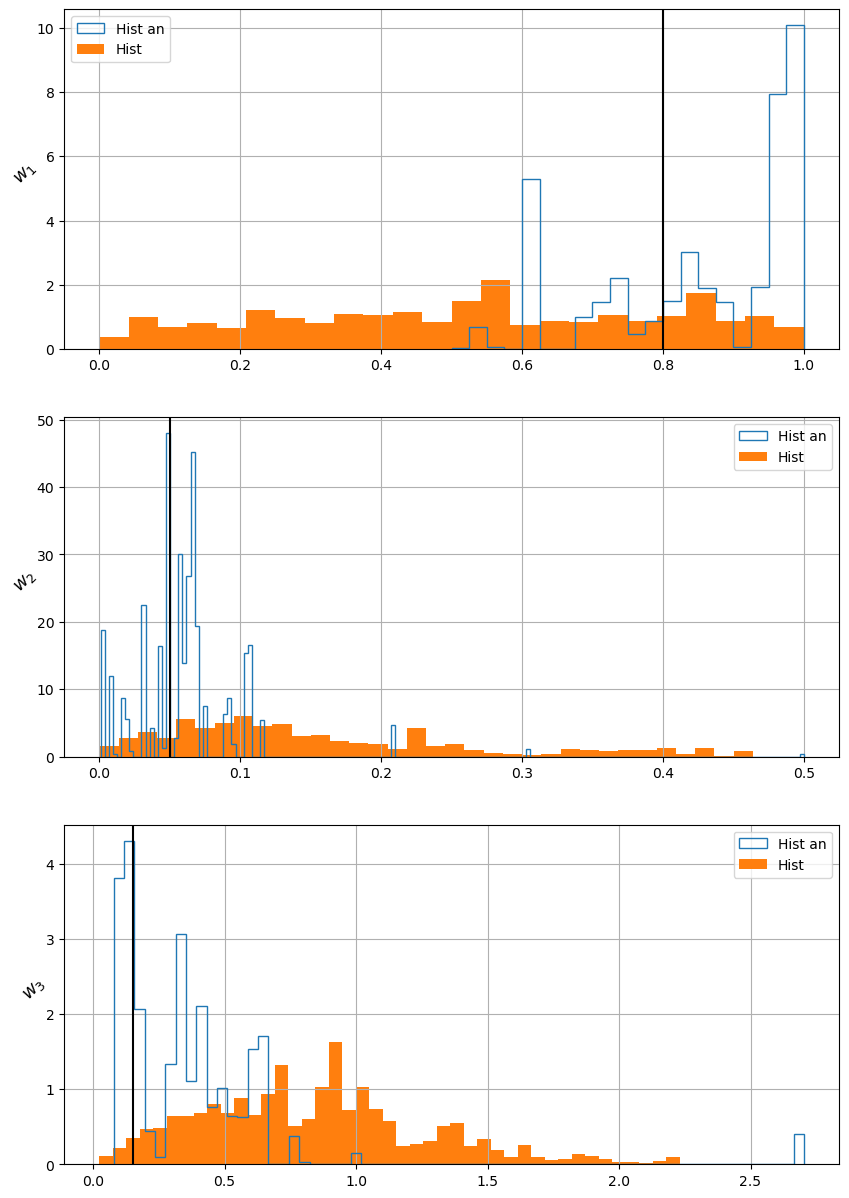

In [1709]:
n_pars = 3
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w1 = samples
w2 = samples_an
#w3 = samples3
for i in range(n_pars):
    #axs[i].hist(np.transpose(w1)[i], density = True, bins = 'auto', label = 'Hist')
    axs[i].hist(np.transpose(w2)[i], density = True, bins = 'auto', histtype='step', label = 'Hist an')
    if i>0: axs[i].hist(np.transpose(w1)[i]*np.sqrt(trans), density = True, bins = 'auto', label = 'Hist')
    else: axs[i].hist(np.transpose(w1)[i], density = True, bins = 'auto', label = 'Hist')
    #axs[i].hist(np.transpose(w3)[i], density = True, bins = 'auto', histtype='step', label = 'Hist2')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(x=parss[i], color = 'black')
    #axs[i].set_ylim([0,100])
#axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

In [1710]:
def p_post(enne):
    px = np.linspace(0,1,enne)
    tp = []
    for p in tqdm.tqdm(px):
        t2 = []
        s2x = np.linspace(0,3,enne)
        for s2 in s2x:
            t1 = []
            s1x = np.arange(0, s2, 3/enne)
            for s1 in s1x:
                t1.append( np.exp( loglikelihood(s, vn, np.array([p, s1, s2])) ) )
            t2.append( np.trapz(np.array(t1), x=s1x) )
        tp.append( np.trapz(np.array(t2), x = s2x) )
    return px, np.array(tp)

p_post(10)

100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

IndexError: index 0 is out of bounds for axis 0 with size 0

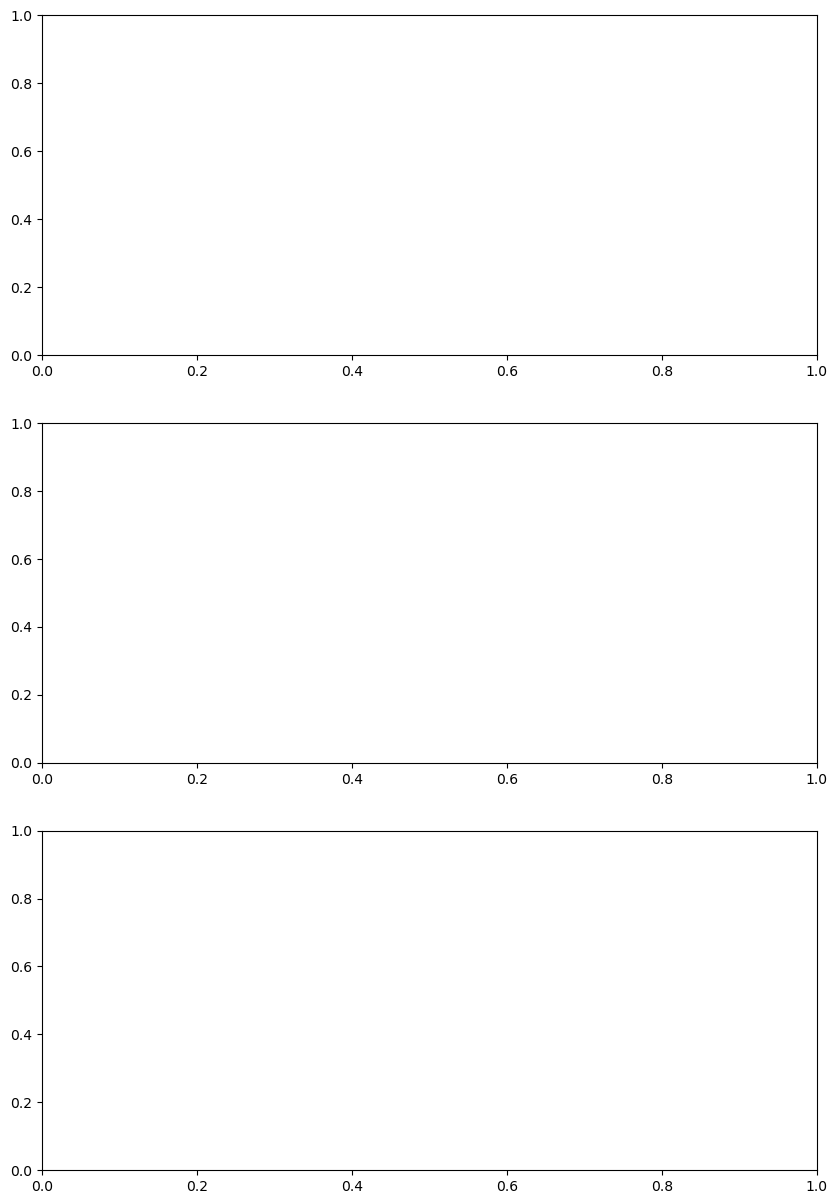

In [1711]:
n_pars = 3
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
w1 = samples2
w2 = samples_an
for i in range(n_pars):
    axs[i].hist(np.transpose(w1)[i], bins = 'auto', label = 'Hist')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', histtype='step', label = 'Hist an')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(x=parss[i], color = 'black')
    #axs[i].set_ylim([0,100])
#axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

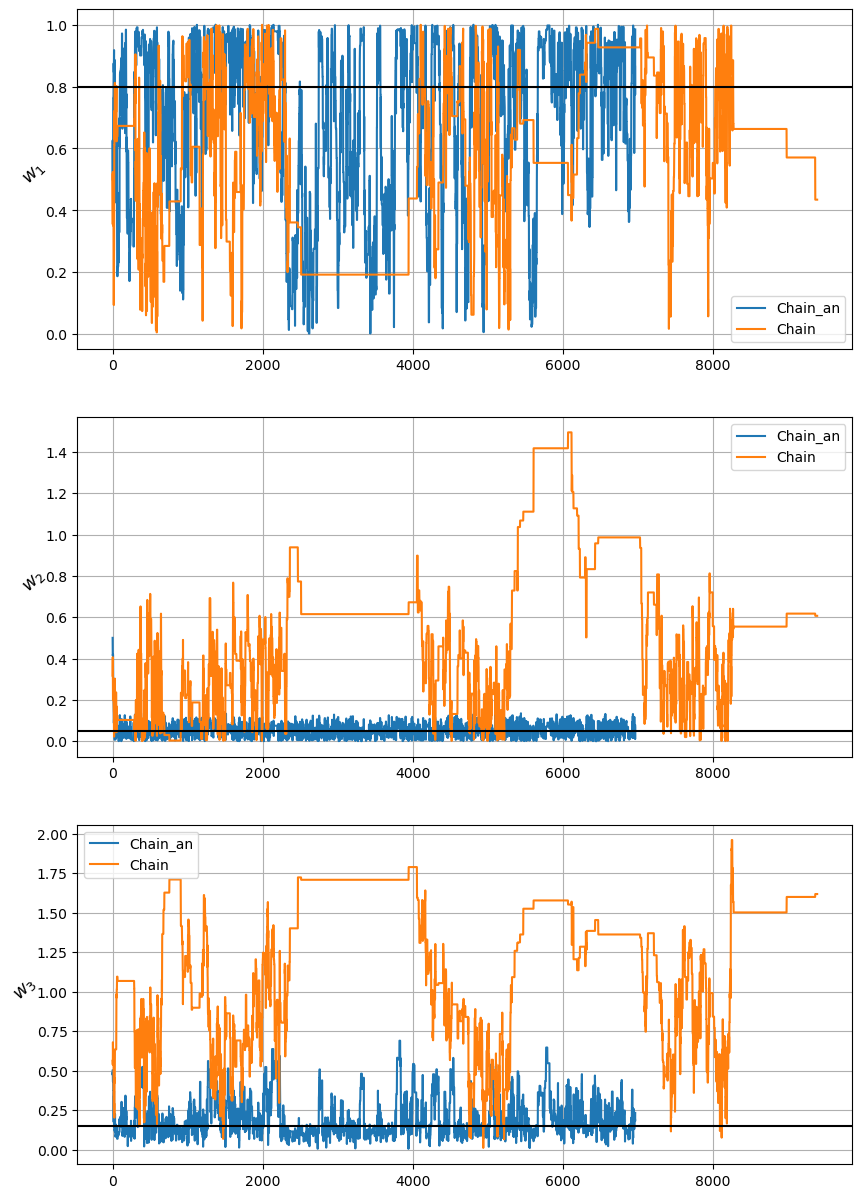

In [ ]:
n_pars = 3
fig, axs = plt.subplots( n_pars, figsize = [10,5*n_pars] )
for i in range(n_pars):
    axs[i].plot(np.arange(len(w2)), np.transpose(w2)[i], label = 'Chain_an')
    axs[i].plot(np.arange(len(w1)), np.transpose(w1)[i], label = 'Chain')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].grid()
    axs[i].legend()
    axs[i].axhline(y=parss[i], color = 'black')
    #axs[i].set_ylim([0,100])
#axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
#plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()